<a href="https://colab.research.google.com/github/renaud-florquin/hands_on_AI/blob/master/Intro2_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First NMIST classifier using fully connected NN and PyTorch

Reference: https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

In [0]:
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


In [2]:
print(torch.__version__)
print(torch.cuda.is_available())

1.2.0
True


### hyperparameters

In [0]:
input_size = 784
output_size = 10

epochs = 100
batch_size = 50
learning_rate = 0.0005

### Train and test data loader

In [0]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,),(0.3081,))])

In [0]:
train_set = torchvision.datasets.MNIST('tmp/', download=True, train=True, transform=transform)
test_set = torchvision.datasets.MNIST('tmp/', download=True, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=True)

Access to the train loader to see the data and format

In [0]:
train_iter = iter(train_loader)
x, y = train_iter.next()

In [7]:
x.shape, y.shape

(torch.Size([50, 1, 28, 28]), torch.Size([50]))

Display the label of the fist batch

In [8]:
print(y.reshape(batch_size//10, 10))

tensor([[3, 6, 4, 4, 3, 9, 5, 1, 1, 7],
        [1, 8, 2, 5, 8, 8, 9, 3, 4, 4],
        [3, 1, 4, 0, 7, 3, 9, 4, 8, 1],
        [1, 8, 1, 7, 0, 8, 9, 7, 8, 1],
        [1, 3, 6, 0, 4, 4, 1, 1, 4, 2]])


Display the x content (batch_size images of handwritten digits)

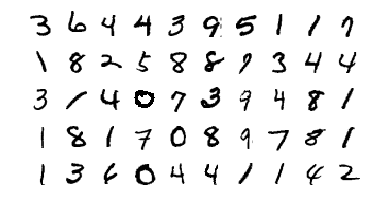

In [9]:
figure = plt.figure()

for index in range(batch_size):
    plt.subplot(6, 10, index+1)
    plt.axis('off')
    plt.imshow(x[index].numpy().squeeze(), cmap='gray_r')
plt.show()

### Neural network definition

In [0]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, output_size)
        
    def forward(self, x):
        z = self.layer1(x)
        z = F.relu(z)
        z = self.layer2(z)
        z = F.relu(z)
        z = self.layer3(z)
        return F.log_softmax(z)

In [11]:
net = Network()
print(net)

Network(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=10, bias=True)
)


Other solution: 

In [0]:
net2 = nn.Sequential(nn.Linear(input_size, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, output_size),
                      nn.LogSoftmax(dim=1))

### Optimizer and Loss function definition

In [0]:
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

### Train function

In [0]:
def train_network():
    running_loss = 0
    net.train()
    for x, y in train_loader:
        # Flatten MNIST images into a 784 long vector
        x = x.view(x.shape[0], -1)      
        optimizer.zero_grad()
        output = net(x)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader.dataset)


### Evaluation function

In [0]:
def test_network():
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.view(x.shape[0], -1)      
            output = net(x)
            test_loss += F.nll_loss(output, y, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(y.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy


### Train phase

In [16]:
metrics = {'avg_train_loss': [], 'avg_test_loss': [], 'test_accuracy': []}
for e in range(epochs):
        avg_train_loss = train_network()
        avg_test_loss, test_accuracy = test_network()
        print('Epooch {:03}/{:03}, Avg. Train loss: {:.4f}, Avg. Test loss: {:.4f}, Accuracy: {:.0f}%'.format(e+1, epochs, avg_train_loss, avg_test_loss, test_accuracy)) 
        metrics['avg_train_loss'].append(avg_train_loss)
        metrics['avg_test_loss'].append(avg_test_loss)
        metrics['test_accuracy'].append(test_accuracy)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epooch 001/100, Avg. Train loss: 0.0223, Avg. Test loss: 0.4292, Accuracy: 88%
Epooch 002/100, Avg. Train loss: 0.0075, Avg. Test loss: 0.3202, Accuracy: 90%
Epooch 003/100, Avg. Train loss: 0.0062, Avg. Test loss: 0.2811, Accuracy: 91%
Epooch 004/100, Avg. Train loss: 0.0055, Avg. Test loss: 0.2512, Accuracy: 92%
Epooch 005/100, Avg. Train loss: 0.0049, Avg. Test loss: 0.2277, Accuracy: 93%
Epooch 006/100, Avg. Train loss: 0.0045, Avg. Test loss: 0.2072, Accuracy: 94%
Epooch 007/100, Avg. Train loss: 0.0040, Avg. Test loss: 0.1915, Accuracy: 94%
Epooch 008/100, Avg. Train loss: 0.0037, Avg. Test loss: 0.1779, Accuracy: 94%
Epooch 009/100, Avg. Train loss: 0.0034, Avg. Test loss: 0.1674, Accuracy: 95%
Epooch 010/100, Avg. Train loss: 0.0032, Avg. Test loss: 0.1523, Accuracy: 95%
Epooch 011/100, Avg. Train loss: 0.0029, Avg. Test loss: 0.1455, Accuracy: 95%
Epooch 012/100, Avg. Train loss: 0.0027, Avg. Test loss: 0.1371, Accuracy: 96%
Epooch 013/100, Avg. Train loss: 0.0025, Avg. Test l

### Display the evolution of the test accuracy

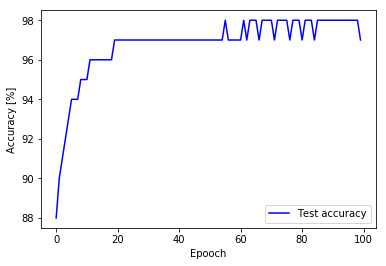

In [17]:
plt.plot(range(epochs), metrics['test_accuracy'], color='blue')
plt.legend(['Test accuracy'], loc='lower right')
plt.xlabel('Epooch')
plt.ylabel('Accuracy [%]')

plt.show()

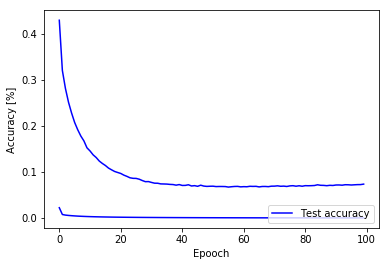

In [18]:
plt.plot(range(epochs), metrics['avg_train_loss'], color='blue')
plt.plot(range(epochs), metrics['avg_test_loss'], color='blue')
plt.legend(['Test accuracy'], loc='lower right')
plt.xlabel('Epooch')
plt.ylabel('Accuracy [%]')

plt.show()